In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [4]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # check the folders from main directory. If there are another files, ignore them
        

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    dummy_df, test_df = train_test_split(df,  train_size= 0.9, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    train_df,valid_df= train_test_split(dummy_df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [19]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (48,48)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar,zoom_range=0.2, width_shift_range = 0.1,
                                         height_shift_range = 0.1,rotation_range=15)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [20]:
#path="/kaggle/working/temp_directory"
path="../input/banglalekha-isolated/BanglaLekha-Isolated/Images/"

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(path)

    # Get Generators
    batch_size = 32
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 119595 validated image filenames belonging to 84 classes.
Found 29899 validated image filenames belonging to 84 classes.
Found 16611 validated image filenames belonging to 84 classes.


In [21]:
from tensorflow.keras import regularizers
from tensorflow.keras.applications.vgg16 import VGG16
#img_size = (80,80)
#base_model2 = ResNet50(include_top= False, weights= "imagenet", input_shape= (128,128,3),pooling='max')
base_model2 = VGG16(include_top= False, weights= "imagenet", input_shape= (48,48,3),pooling='max')
base_model2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [22]:
for layer in base_model2.layers:
    layer.trainable=False

In [33]:
model2 = Sequential([
    base_model2,
    #Flatten(),
    BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001),
    Dropout(rate= 0.25),
    Dense(512,   activation= 'relu'),
    #Dense(84, activation= 'softmax')
    BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001),
    Dropout(rate= 0.25),
    Dense(512,   activation= 'relu'),
    Dense(84, activation= 'softmax')
])
from tensorflow.keras.optimizers import Adam
model2.compile(optimizer=Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= METRICS)

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_6 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 512)              

In [32]:
import tensorflow as tf

METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

In [34]:
history=model2.fit(train_gen, epochs=20, batch_size=32,  validation_data = (valid_gen))

Epoch 1/20
3738/3738 [==============================] - 950s 253ms/step - loss: 2.9417 - accuracy: 0.2717 - precision: 0.7010 - recall: 0.0964 - val_loss: 2.1612 - val_accuracy: 0.4335 - val_precision: 0.7608 - val_recall: 0.2135
Epoch 2/20
3738/3738 [==============================] - 388s 104ms/step - loss: 2.3369 - accuracy: 0.3803 - precision: 0.6978 - recall: 0.1929 - val_loss: 1.9785 - val_accuracy: 0.4800 - val_precision: 0.7690 - val_recall: 0.2754
Epoch 3/20
3738/3738 [==============================] - 312s 83ms/step - loss: 2.2139 - accuracy: 0.4070 - precision: 0.7078 - recall: 0.2236 - val_loss: 1.8628 - val_accuracy: 0.5006 - val_precision: 0.7818 - val_recall: 0.3011
Epoch 4/20
3738/3738 [==============================] - 309s 83ms/step - loss: 2.1472 - accuracy: 0.4209 - precision: 0.7152 - recall: 0.2401 - val_loss: 1.7848 - val_accuracy: 0.5160 - val_precision: 0.7952 - val_recall: 0.3178
Epoch 5/20
3738/3738 [==============================] - 311s 83ms/step - loss: 2.1

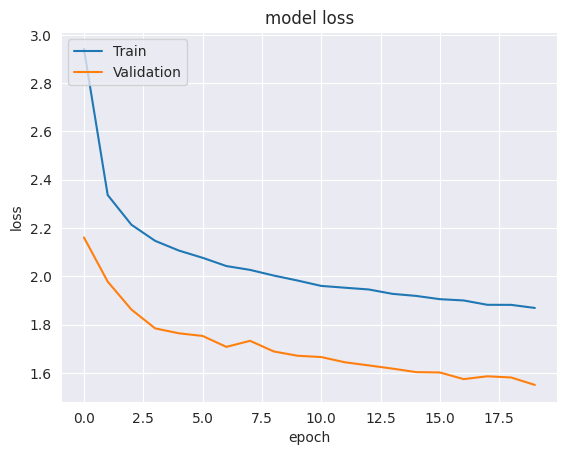

In [35]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()